## Introduction to TensorFlow
We will be fitting a sin(x) curve in this notebook 

In [1]:
#!pip install --upgrade numpy
#!pip install tensorflow==1.5

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1)

## Getting Some Data To Fit
**The first step in any good machine learning workflow is to get some data.** For this notebook we are just going to be fitting a sin curve with some Gaussian noise, so the data will be generated. The steps are then to
1. Get the data by sampling data points in a sin(x) curve
2. Add noise
3. Build model
4. Fit model

In [3]:
# Build a linear sampling space for the x values we will sample
inputs = np.linspace(-5000, 5000, 100000)
# Take the sin of the input "x" values to get our labels
outputs = np.sin(inputs)

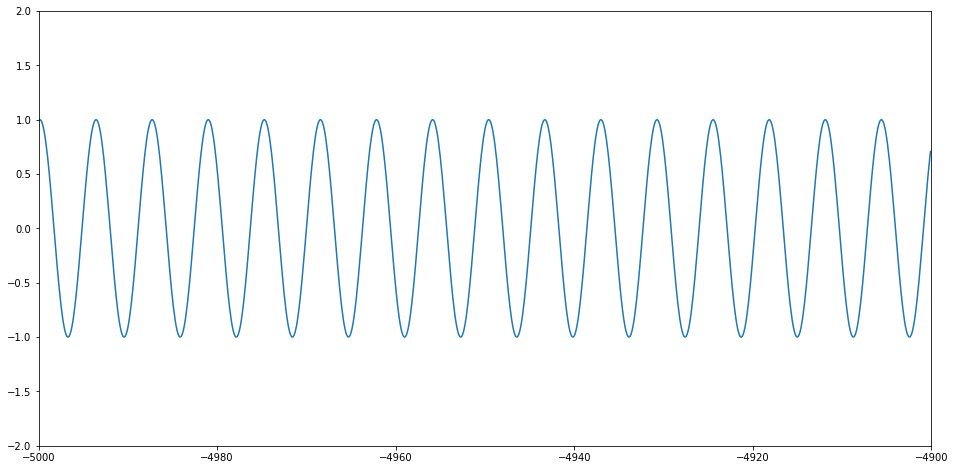

In [4]:
# Plot some of the data
plt.figure(figsize=(16, 8))
plt.axis([-5000, -4900, -2, 2])
plt.plot(inputs[0:1000], outputs[0:1000])

Now we add noise to the data to make it realistic, data in the real world is **always** noisy. We are sampling noise from a normal (Gaussian) distribution with low variance.

In [5]:
standard_deviation = 1e-1 # The standard deviation of the noise distribution we want
num_samples = inputs.shape[0]
# Sample some random noise
random_noise = np.random.normal(loc=0, scale=standard_deviation, size=num_samples)

In [6]:
# Add the noise to our inputs
noisy_outputs = random_noise + outputs

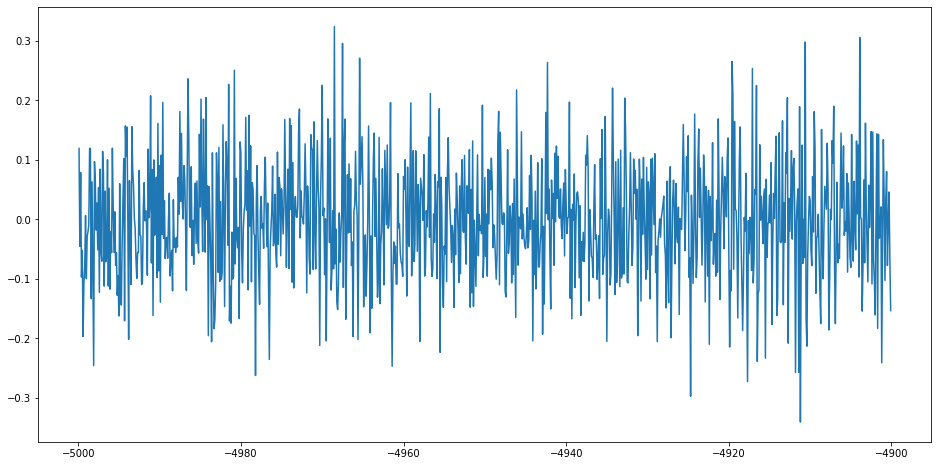

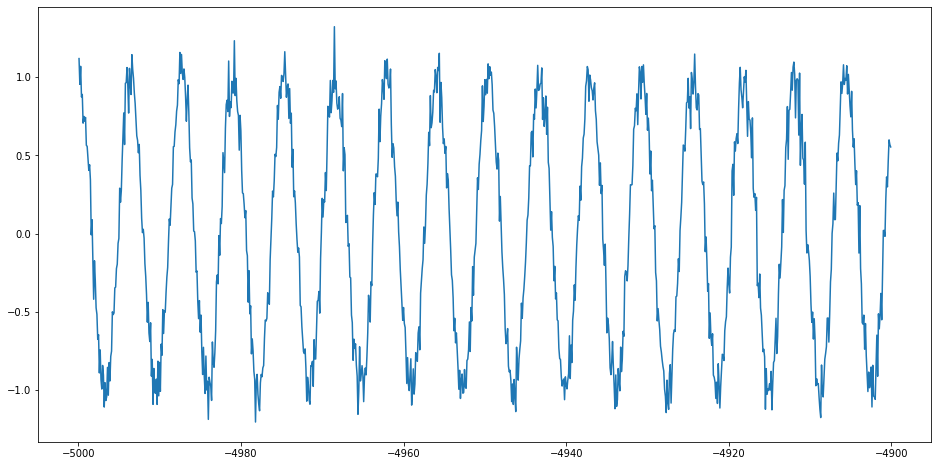

In [7]:
plt.figure(figsize=(16,8))
plt.plot(inputs[1:1000], random_noise[1:1000])
plt.show()

# Plot the data with noise
plt.figure(figsize=(16, 8))
plt.plot(inputs[1:1000], noisy_outputs[1:1000])
plt.show()

## Model Building

So we have our noisy data, lets try to fit this with a deep neural network using TensorFlow. <br/>
**Note:** In reality you'd probably never use a neural net for this, you'd use linear regression but that's not why we're here ¯\\_(ツ)_/¯

### Brief TLDR; on TensorfFlow
TensorFlow is a useful Python library that we often use in deep learning. TensorFlow is intentionally built very generically to allow users to do pretty much anything with their models. Although TensorFlow is thought of as a deep learning library its core features are fairly basic. That is, TensorFlow can<br/>
1. Build arbitrarily complicated computation graphs.
2. Take derivatives/gradients through this graph which allows us to (for example) train models.
<br/><br/>

All of Tensorflow essentially boils down to building a computation graph and then optimizing it. So first **what is a computation graph?** A computation graph is just a **directed graph** (remember CS70) where the vertices of the graph are **values called tensors** (numbers, matrices, vectors) or **operations** (multiplication, addition, concatenation, convolution). Since we can build all of the operations in mathematics from a few fundamental ones, a computation graph can completely express any function. **Below** is an example of the formula $\frac{ab}{a + b}$ evaluated for $(a, b) = (15, 5)$.
<br/><br/>

![](https://miro.medium.com/max/2994/1*vPb9E0Yd1QUAD0oFmAgaOw.png)

**How does TensorFlow handle computation graphs?**<br/>
Computation graphs in TF are built on a few core concepts<br/>
- [Constants](https://www.tensorflow.org/api_docs/python/tf/constant) `tf.constant(value, dtype=None, shape=None, name='Const')`: holds constants like pi or acceleration due to gravity.
- [Placeholders](https://www.tensorflow.org/versions/r1.14/api_docs/python/tf/placeholder) `tf.placeholder(dtype, shape=None, name=None)`: graph node for something we will pass in (e.g. inputs to a model or labels to train on)
- [Variables](https://www.tensorflow.org/versions/r1.14/api_docs/python/tf/Variable) `tf.Variable(initial_value=None, shape=None, trainable=None)`: holds variables that you may train in the graph or may change throughout computation.
- [Operations](https://www.tensorflow.org/api_docs/python/tf/Operation): means of operating and transforming the above three graph elements and more.
<br/><br/>

These fundamental core objects (along with a few others) make up the majority of all TF graphs. **Note:** Tensorflow calls all these intermediate values (constants, placeholders, variables) **tensors** and tracks maintains data on them as well as outputs of operations as they **flow** through the graph.

Deep learning models are often incredibly complex and it would be a pain to have to build these models from scratch every time we want to use them, so the software engineers at Google built another level of abstraction into TensorFlow called the **layers** API. This API [linked here](https://www.tensorflow.org/versions/r1.14/api_docs/python/tf/layers) is incredibly useful and defines all the variables and computational elements for you for most things you will ever need to do. **Note:** TF still gives you the ability to define new layers if you so wish. Lets see an example, suppose we wanted to build a convolutional neural network. Instead of defining the [convolution](https://en.wikipedia.org/wiki/Convolution) operation ourselves in terms of addition, multiplication, and complicated indexing, we can just call `tf.layers.conv2d(inputs, filters, kernel_size, ...)` as per the [documentation](https://www.tensorflow.org/versions/r1.14/api_docs/python/tf/layers/conv2d).

In this notebook we are going to build a two layer neural network where each layer is a **fully connected** layer (the simplest NN layer that is really just a matrix multiplication).

**First:** We want to define our placeholders (tensors that initially have no value but where we will store our inputs and labels in the graph). Use the documentation [here](https://www.tensorflow.org/versions/r1.14/api_docs/python/tf/placeholder) and data type `tf.float32`

In [8]:
tf.reset_default_graph()

In [9]:
# Build input and output placeholders
graph_input = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="Input_Holder")
graph_labels = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="Output_Holder")

In [10]:
output = graph_input
output = tf.layers.Dense(124, activation='relu')(output)
output = tf.layers.Dense(124, activation='relu')(output)
output = tf.layers.Dense(1)(output)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
loss = tf.losses.mean_squared_error(output, graph_labels)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
lr = 1e-3 # The learning rate we will use for training
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op = optimizer.minimize(loss) # Calling this operation will make a training step on the graph

In [13]:
# Build a session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [14]:
epochs = 200
inputs = inputs.reshape((-1, 1))
noisy_outputs = noisy_outputs.reshape((-1, 1))
losses = []

# Run training script
for i in range(epochs):
    feed_dict = {
        graph_input: inputs,
        graph_labels: noisy_outputs
    }
    
    this_loss, _ = sess.run((loss, train_op), feed_dict=feed_dict)
    losses.append(this_loss)
    
    if i % 50 == 0 or i == epochs - 1:
        print(f"Loss on epoch {i} was: {this_loss}")

Loss on epoch 0 was: 820.5357666015625
Loss on epoch 50 was: 39.98247528076172
Loss on epoch 100 was: 0.9116256237030029
Loss on epoch 150 was: 0.51096510887146
Loss on epoch 199 was: 0.5093852281570435


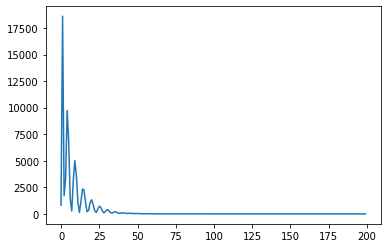

In [15]:
plt.plot(range(epochs), losses)